# テキストデータの読み書きについて

Pythonでテキストデータを処理する場合, 以下の方法が考えられる:

1. [`open`関数で各行を処理する](#open関数を使用した場合)
2. [`numpy.loadtxt`関数で, `ndarray`として読み込む](#NumPyを使用した場合)
3. [`pandas.read_csv`関数で, `DataFrame`として読み込む](#DataFrameで読み込む方法)

これら3つの方法について, カンマ区切り(CSV)と空白区切りのそれぞれについて解説する.  
結論から言うと, **`pandas`を用いるのが最も容易かつ有用**である. `pandas`を使う方法のみ知りたい方は[こちら](#DataFrameで読み込む方法).

なおデータは, 
- [USGS Earthquake Catalog (U.S. Geological Survey, 2020)](https://earthquake.usgs.gov/earthquakes/search/) 
- 気象庁 [JMA2001 一次元速度モデル (Ueno et al., 2002)](https://www.data.jma.go.jp/svd/eqev/data/bulletin/catalog/appendix/trtime/trt_j.html)

から借用する

今回使用したバージョンは以下の通り:

|Version|
|:-----:|
|Python 3.8.5|
|NumPy 1.19.1|
|pandas 1.1.2|

## 目次

- [CSVデータ](#CSVデータ)
    - [open関数を使用した場合](#open関数を使用した場合)
    - [NumPyを使用した場合](#NumPyを使用した場合)
    - [DataFrameで読み込む方法](#DataFrameで読み込む方法)
- [空白区切りのデータ](#空白区切りのデータ)
- [テーブルデータの書き出し方法](#テーブルデータの書き出し方法)

## CSVデータ

### 地震カタログのダウンロード

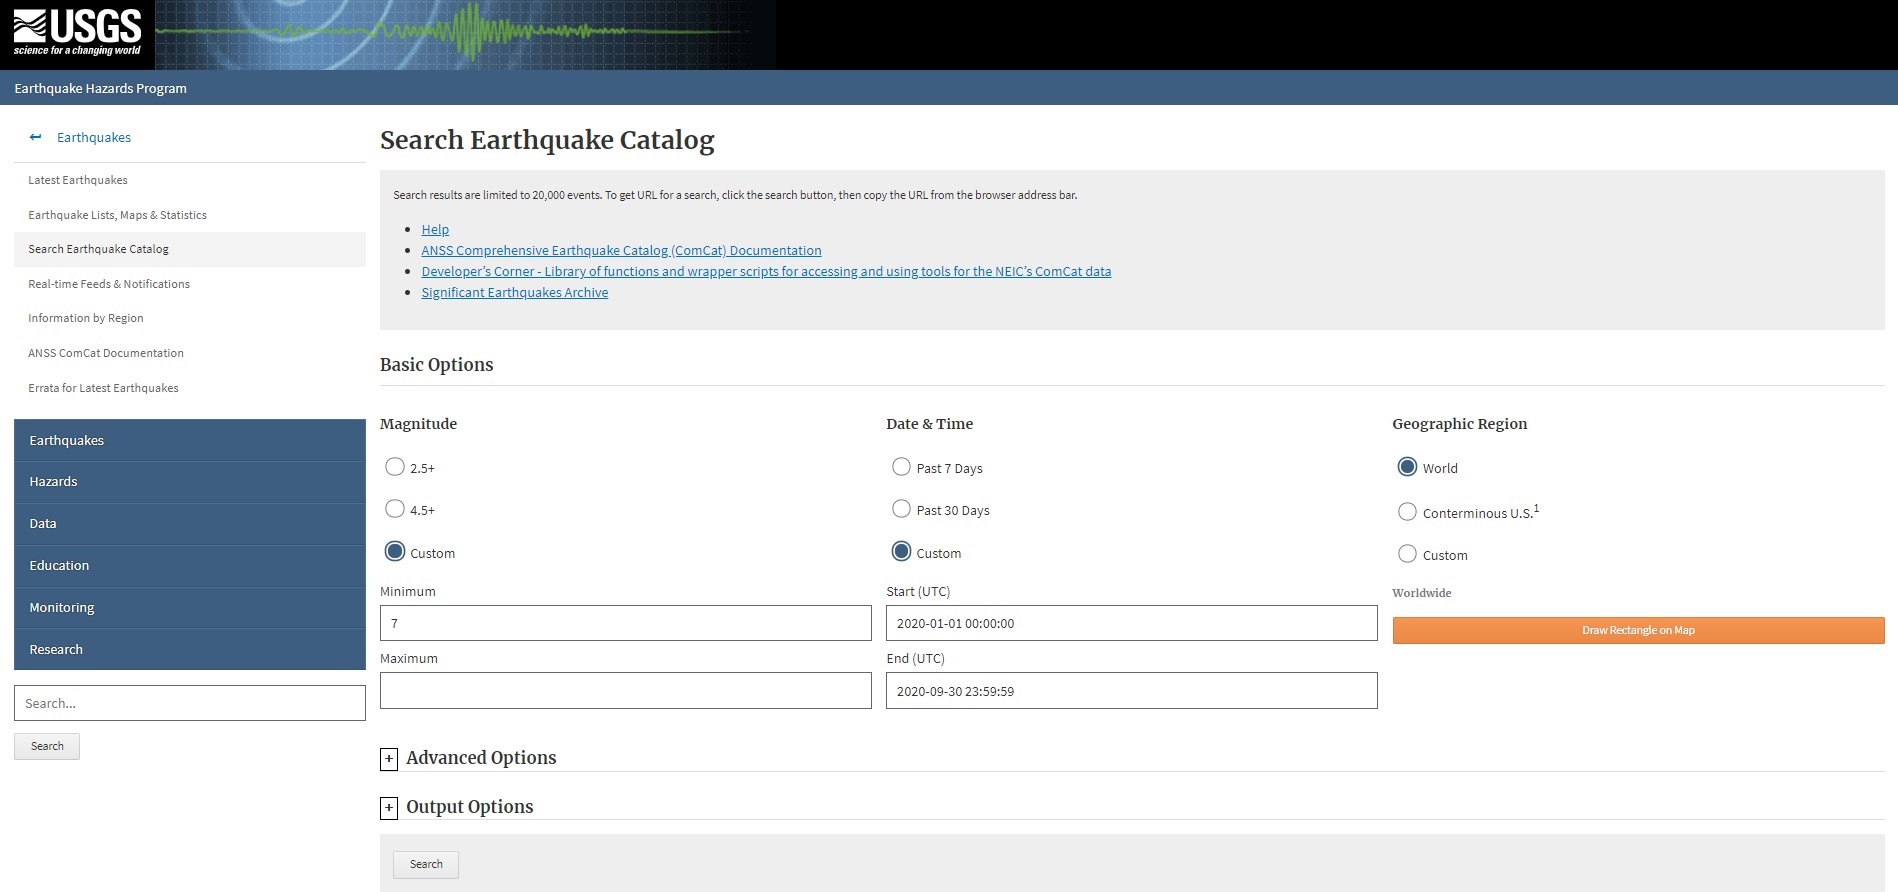

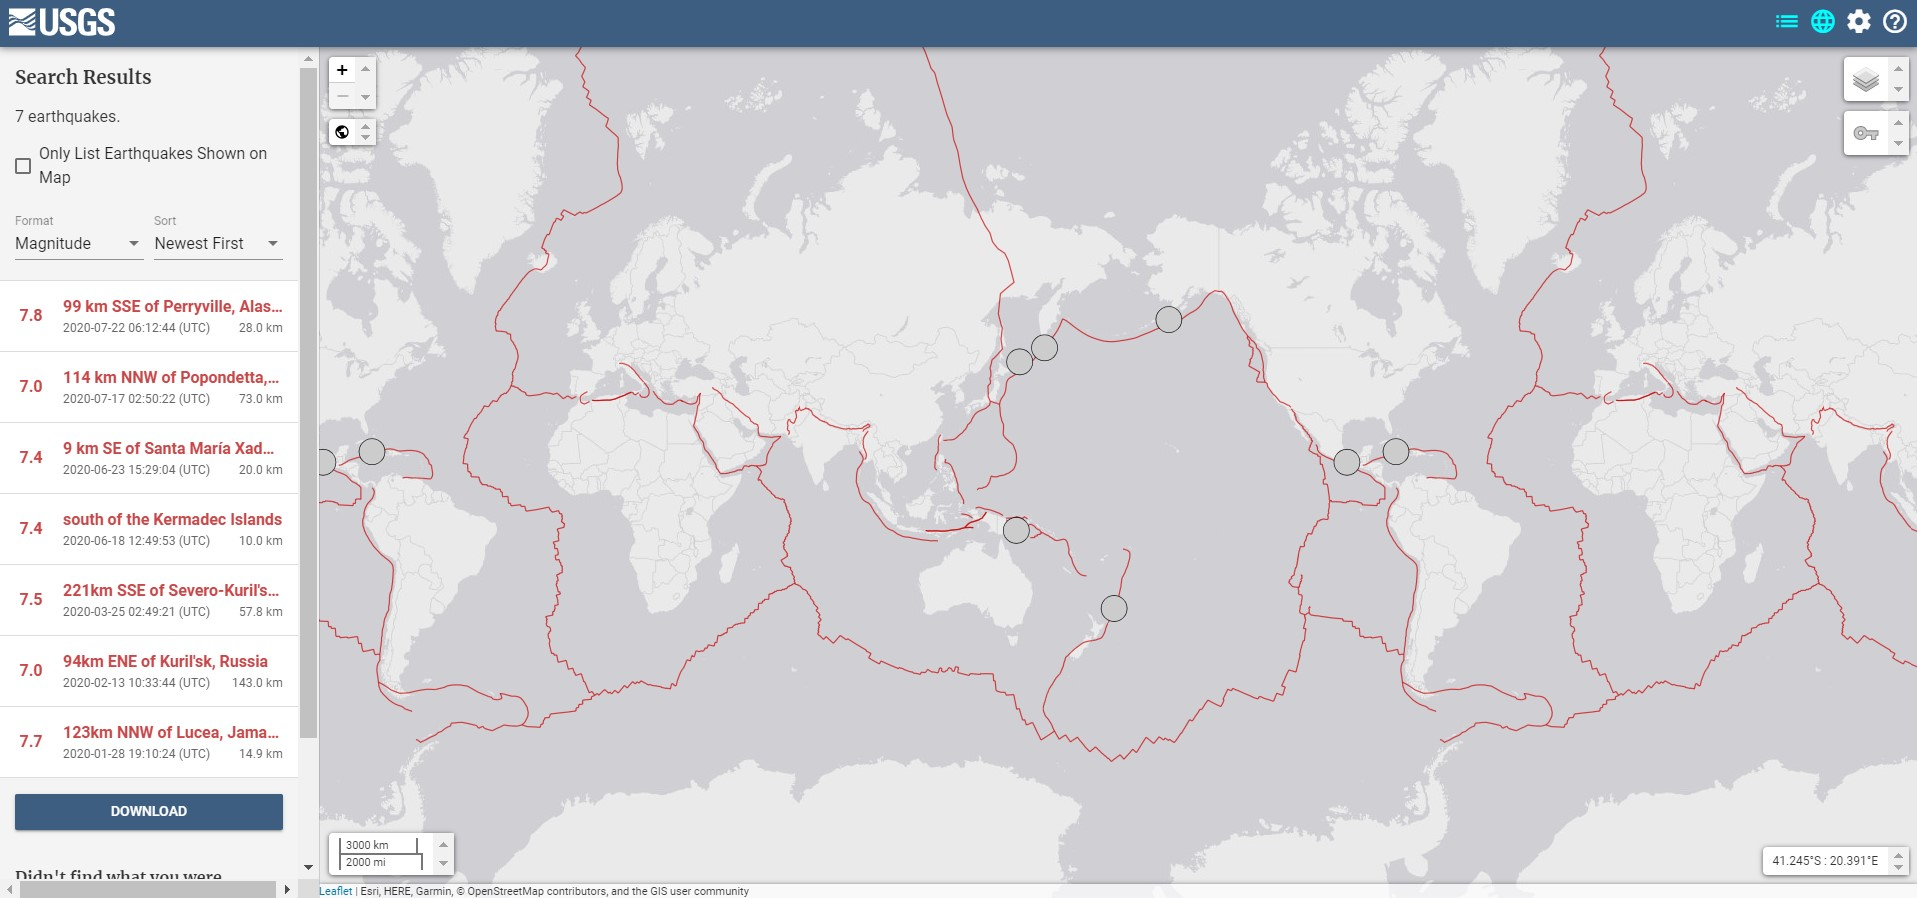

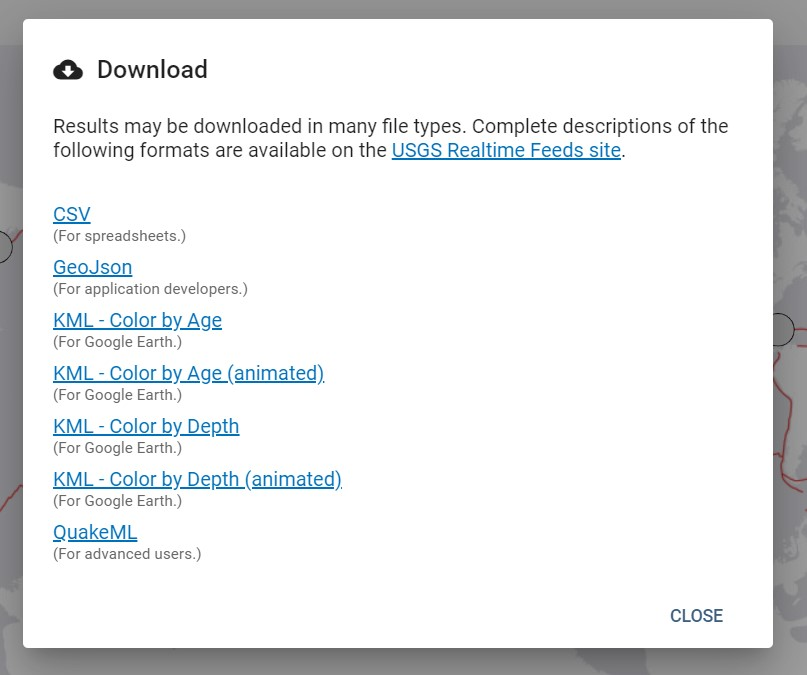

`query.csv`がダウンロードできる

### open関数を使用した場合

`open`関数は様々なフォーマットのファイルを開くことができる. 
例えば, .txt, .csv, .png, .mp3, ... など, バイナリファイルでも可能.

```python
>>> open(file='/path/to/file.csv', mode='r', encoding='UTF-8')
```

`mode`とは, 読み込み（`'r'`）か書き込み（上書きは`'w'`, 追記は`'a'`）のこと. バイナリファイルの場合, `'b'`を加えておく.

`open`関数はファイルを開けるだけであり, **開けたファイルを確実に閉じる**必要がある(`f.close()`)ことから, やや面倒である. 
そのために, **with構文**を使って, 開始から終了までをまとめて処理するのが良い.

まずは, ファイル全体を読み込んでみる  
ファイルオブジェクト（ここでは`f`）の`read()`メソッドを使う

In [ ]:
with open('query.csv', mode='r') as f:
    s1_1 = f.read()

s1_1

ファイル全体を文字列として読み込めたが, せめて行で区切りたい（改行コード`'\n'`）

その場合, `f.readlines()`を使う

In [ ]:
with open('query.csv', mode='r') as f:
    s1_2 = f.readlines()

s1_2

分かりにくいが, 各行で分割されたlistとなっている

In [ ]:
len(s1_2)

しかし, 区切り文字で分割したいのが通常だろう. その場合, **`f.readline()`で各行を読み込み, 全ての行をループ**すればよい.

In [ ]:
with open('query.csv', mode='r') as f:
    while True:
        s_tmp = f.readline()
        print(s_tmp)
        if not s_tmp:
            break

区切り文字（CSVは`','`）で分割したい場合, `split(',')`メソッドを使う

In [ ]:
s1_3 = []

with open('query.csv', mode='r') as f:
    # header
    s1_header = f.readline().split(',')
    
    # contents
    while True:
        s_tmp = f.readline()
        if not s_tmp:
            break
        s1_3.append(s_tmp.split(','))

辞書形式`dict`を使う方法もある

In [ ]:
s1_4 = {}

with open('query.csv', mode='r') as f:
    # header
    s1_header = f.readline().split(',')
    
    # contents
    num = 0
    while True:
        num += 1
        dict_tmp = {}
        s_tmp = f.readline()
        if not s_tmp:
            break
            
        for key, val in zip(s1_header, s_tmp.split(',')):
            dict_tmp[key] = val
        
        s1_4[num] = dict_tmp

In [ ]:
s1_4[3]

JSONファイルなどの取り扱いに近く, 処理も統一的で速い...
が, 面倒さは拭えない…

次に`numpy.loadtxt`を使って, 呼び出してみよう

### NumPyを使用した場合

`NumPy`はPythonで必須の高速計算パッケージであり, `ndarray`というデータ構造を使用する  
`np.loadtxt`も`ndarray`を返却することから, その後の処理で使いやすい

詳しくは [numpy.loadtxt](https://numpy.org/doc/stable/reference/generated/numpy.loadtxt.html) を参照のこと.

In [ ]:
## NumPyのインポート
import numpy as np

追加の引数無しで読み込んでみる

In [ ]:
np.loadtxt('query.csv')

早速エラーが発生した. これはデフォルトのdtypeが`float`であることによる. ここは一先ず`str`にして, timeからmagまで読み込んでみる

In [ ]:
np.loadtxt(
    'query.csv', 
    dtype='str', 
    delimiter=',', 
    usecols=range(5),
)

読み込みに成功した. ここで主要な引数を確認してみよう

```python
>>> np.loadtxt(fname,dtype,comments,delimiter,skiprows,usecols,encoding)
```

|パラメータ|説明|
|:---:|:---|
|fname|ファイルのパス|
|dtype|データタイプ, デフォルトは`'float'`|
|comments|コメント行とみなされる先頭の文字, デフォルトは`'#'`|
|delimiter|区切り文字, **CSVでは`','`と設定**する|
|skiprows|指定した行数だけ上から読み込まない|
|usecols|読み込む列番号を指定可能|

データフォーマットは各列でも設定可能

In [ ]:
s2 = np.loadtxt(
    'query.csv', 
    dtype=[
        ('col1','S24'), ('col2','float'), ('col3','float'),
        ('col4','float'), ('col5','float'),
    ], 
    delimiter=',', 
    skiprows=1,
    usecols=range(5),
)

In [ ]:
s2[1:3]

`open`関数の場合より遥かに容易だが, テーブルデータとして扱うには難がある.  
そこで, 直接`pandas.DataFrame`として読み込む方法を説明する

### DataFrameで読み込む方法

`pandas.DataFrame`は, 2次元表形式のデータ構造であり, 非常に有用性が高いとされている  
ここでは`DataFrame`の使用方法は割愛し, ファイルの読み書きを解説する

まずは, `pandas.read_csv`メソッドを追加の引数無しで使ってみよう（便宜上, usecolsのみ使用）

In [ ]:
## pandasのインポート
import pandas as pd

In [ ]:
pd.read_csv('query.csv', usecols=range(5))

驚くことに, 複雑な引数無しでもデータの読み込みに成功した.  
`pd.read_csv()`では, デフォルトの区切り文字を`','`としていることや, 自動的に1行目をヘッダーとして扱うことなどが影響している

一方で引数の種類も多く, 様々なデータ形式に対応できる.

In [ ]:
s3 = pd.read_csv(
    'query.csv', 
    usecols=range(5), 
    skiprows=1,
    names=('Datetime','Latitude','Longitude','Depth','Mag'),
    parse_dates=[0]
)
s3

In [ ]:
print(s3.Datetime.dtype)

- 引数`names`は各列名を指定する
- 引数`parse_dates`で0列目(`'Datetime'`)を選択すると, `datetime`型(UTC)に変換できる

## 空白区切りのデータ

### データのダウンロード

[気象庁のHP](https://www.jma.go.jp/jma/index.html)から, [JMA2001](https://www.data.jma.go.jp/svd/eqev/data/bulletin/catalog/appendix/trtime/trt_j.html)の空白区切りデータをダウンロードする.  
「速度構造ファイル > vjma2001.zip」 をダウンロードし, テキストデータの vjma2001 を取り出す

### open関数の場合

#### listで受け取る

In [ ]:
vjma1_1 = []
with open('vjma2001', mode='r') as f:
    while True:
        vtmp = f.readline().split()
        if not vtmp:
            break
        vjma1_1.append([*map(float, vtmp)])

len(vjma1_1)

In [ ]:
vjma1_1[:5]

- `split()`は空白区切り, `str`のリスト(`vtmp`)を返す
- `[*map(float, vtmp)]`は, `vtmp`全てを`float`に変換し, リストに格納

#### ndarrayで受け取る

In [ ]:
with open('vjma2001', mode='r') as f:
    vtmp = f.readlines()

vjma1_2 = np.array([
    [*map(float, fi.split())] for fi in vtmp
])

In [ ]:
vjma1_2

- `f.readlines()`で一括読み込み
- `ndarray`内でfor文を回す（[**内包表記は高速**](https://qiita.com/y__sama/items/a2c458de97c4aa5a98e7)）

    ⇒ やはり面倒で, できるならこの方法は避けたい

### np.loadtxtの場合

In [ ]:
np.loadtxt('vjma2001')

データのフォーマット自体がシンプルな場合, `np.loadtxt`が有効. 勝手に空白文字でsplitしてくれる. コメント行は引数`comments`などで回避する. 

### Dataframeの場合

In [ ]:
pd.read_csv(
    'vjma2001', 
    delim_whitespace=True,
    header=None,
    names=('Vp','Vs','Depth'),
)

空白区切りの場合, `delim_whitespace=True`が必要

## テーブルデータの書き出し方法

`DataFrame`の`to_XXX`メソッドを使えば, 多様なフォーマットで出力できる

次のようなデータを扱ってみよう

In [ ]:
from io import StringIO
fluit_data1 = (
"""fluit,numbers,price
apple,279,90.8
grape,92,219.2
banana,392,118
peach,73,135"""
)

df_fluit = pd.read_csv(
    StringIO(fluit_data1),
    index_col='fluit'  # indexを'fluit'に設定
)
df_fluit

- CSV

In [ ]:
df_fluit.to_csv('output1_1.csv')

pd.read_csv('output1_1.csv')

`index`を`False`にすると各列のデータのみが出力される（indexのないデータ向け）

`columns`を指定すると, その列のデータだけ取り出せる

In [ ]:
df_fluit.to_csv('output1_2.csv', columns=['price',])

pd.read_csv('output1_2.csv')

- pickle

`pickle`はpython独自のフォーマットで, **オブジェクトをそのまま保存**できる

In [ ]:
df_fluit.to_pickle('output2_1.pickle')

In [ ]:
import pickle

with open('output2_1.pickle','rb') as f:
    pickled_fluit = pickle.load(f)

pickled_fluit

- html

In [ ]:
df_fluit.to_html()

- Excel（使い道は少ないが）

In [ ]:
df_fluit.to_excel('output3_1.xlsx')

他に, python内で使えるオブジェクトにも書き換えられる

In [ ]:
df_fluit.to_dict()

In [ ]:
df_fluit.to_numpy()